Last week I scrapped a bunch of data from the Steam API using my [Steam Graph Project](https://github.com/jrtechs/SteamFriendsGraph).
This project captures steam users, their friends, and the games that they own.
Using the Janus-Graph traversal object, we are able to use the Gremlin graph query language to pull this data.
Since I am storing the hours played in a game as a property on the relationship between a player and a game node, I had to do a join statement to get the hours property with the game information in a single query.  

```java
Object o = graph.con.getTraversal()
    .V()
    .hasLabel(Game.KEY_DB)
    .match(
            __.as("c").values(Game.KEY_STEAM_GAME_ID).as("gameID"),
            __.as("c").values(Game.KEY_GAME_NAME).as("gameName"),
            __.as("c").inE(Game.KEY_RELATIONSHIP).values(Game.KEY_PLAY_TIME).as("time")
    ).select("gameID", "time", "gameName").toList();
WrappedFileWriter.writeToFile(new Gson().toJson(o).toLowerCase(), "games.json");
```

Using the game indexing property on the players, I noted that I only ended up fully indexing the games of 481 games. 

```java
graph.con.getTraversal()
    .V()
    .hasLabel(SteamGraph.KEY_PLAYER)
    .has(SteamGraph.KEY_CRAWLED_GAME_STATUS, 1)
    .count().next()
```

We now transition to python and Matlptlib to visualize the data exported from our JanusGraph Query as a json object.
The dependencies for this [notebook](https://github.com/jrtechs/RandomScripts/tree/master/notebooks) can be installed using pip.

In [2]:
!pip install pandas
!pip install matplotlib

     |████████████████████████████████| 10.0 MB 4.3 MB/s eta 0:00:01
     |████████████████████████████████| 510 kB 2.9 MB/s eta 0:00:01


The first step we are doing is importing our JSON data as a pandas dataframe.
Pandas is a popular open-source data analysis and manipulation tool.
I enjoy pandas because it has native integration with matplotlib and supports operations like aggregations and groupings. 

In [154]:
import matplotlib.pyplot as plt
import pandas as pd

games_df = pd.read_json('games.json')
games_df

,gameid,time,gamename
0,210770,243,sanctum 2
1,210770,31,sanctum 2
2,210770,276,sanctum 2
3,210770,147,sanctum 2
4,210770,52,sanctum 2
...,...,...,...
36212,9800,9,death to spies
36213,445220,0,avorion
36214,445220,25509,avorion
36215,445220,763,avorion


Using the built-in matplotlib wrapper function, we can graph a historgram of the number of hours played in a game.

Text(0, 0.5, 'Frequency')

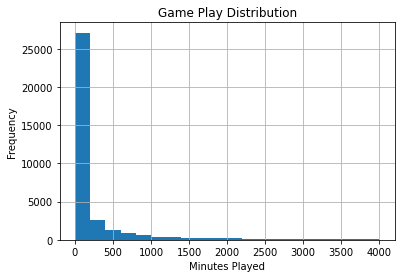

In [21]:
ax = games_df.hist(column='time', bins=20, range=(0, 4000))
ax=ax[0][0]
ax.set_title("Game Play Distribution")
ax.set_xlabel("Minutes Played")
ax.set_ylabel("Frequency")

Notice that the vast majority of the games are rarely ever played, however, it is skewek to the right with a lot of outliers.
We can change the scale to make it easier to view using the range parameter.

Text(0, 0.5, 'Frequency')

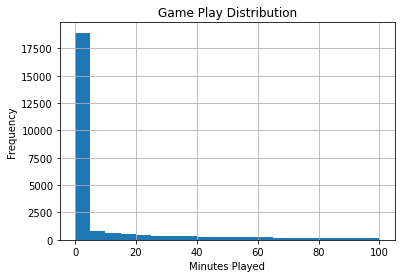

In [28]:
ax = games_df.hist(column='time', bins=20, range=(0, 100))
ax=ax[0][0]
ax.set_title("Game Play Distribution")
ax.set_xlabel("Minutes Played")
ax.set_ylabel("Frequency")

If we remove games that have never been played, the distribution looks more normal.

Text(0, 0.5, 'Frequency')

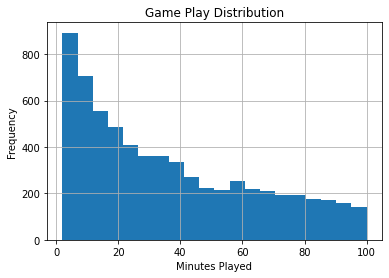

In [155]:
ax = games_df.hist(column='time', bins=20, range=(2, 100))
ax=ax[0][0]
ax.set_title("Game Play Distribution")
ax.set_xlabel("Minutes Played")
ax.set_ylabel("Frequency")

Although historgrams are useful, viewing the CDF is often more useful since it is easier to extract numerical information from.

Text(0, 0.5, 'Frequency')

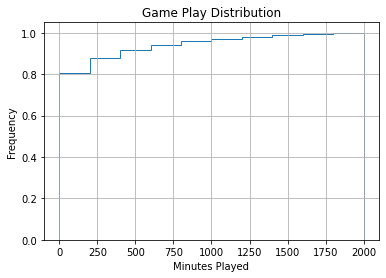

In [90]:
ax = games_df.hist(column='time',density=True, range=(0, 2000),  histtype='step',cumulative=True)
ax=ax[0][0]
ax.set_title("Game Play Distribution")
ax.set_xlabel("Minutes Played")
ax.set_ylabel("Frequency")

80% of people who owns a game plays it under 4 hours. In fact, nearly half of all downloaded or purchased steam games go un-played. This is a cool example of famous 80/20 principle -- aka Pareto principle. The Pareto principle states that for most events, roughly 80% of the effects from 20% of the causes.

As mentioned earlier, the time in owned game distribution is heavily skewed to the right.

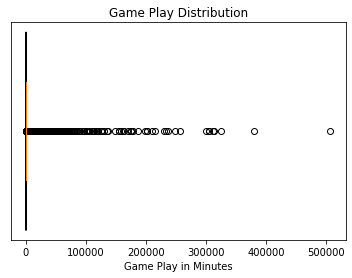

In [31]:
ax = plt.gca()
ax.set_title('Game Play Distribution')
ax.boxplot(games_df['time'], vert=False,manage_ticks=False, notch=True)
plt.xlabel("Game Play in Minutes")
ax.set_yticks([])
plt.show()

Zooming in on the distribution we see that nearly half of all the purchased games go un-opened.

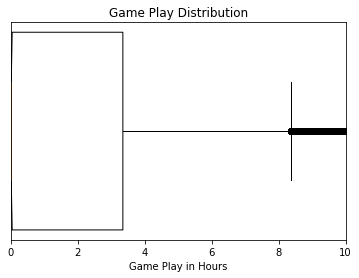

In [80]:
ax = plt.gca()
ax.set_title('Game Play Distribution')
ax.boxplot(games_df['time']/60, vert=False,manage_ticks=False, notch=True)
plt.xlabel("Game Play in Hours")
ax.set_yticks([])
ax.set_xlim([0, 10])
plt.show()

Viewing the aggregate pool of hours in particular game data is insightful, however, comparing different games against each other is more interesting.
In pandas, after we create a grouping on a column, we can aggregate it into metrics such as max, min, mean, etc.
I am also sorting the data I get by count since we are more interested in "popular" games.

In [160]:
stats_df = (games_df.groupby("gamename")
                    .agg({'time': ['count', "min", 'max', 'mean']})
                    .sort_values(by=('time', 'count')))
stats_df

time                          
                                 count min     max          mean
gamename                                                        
龙魂时刻                                 1  14      14     14.000000
gryphon knight epic                  1   0       0      0.000000
growing pains                        1   0       0      0.000000
shoppy mart: steam edition           1   0       0      0.000000
ground pounders                      1   0       0      0.000000
...                                ...  ..     ...           ...
payday 2                           102   0   84023   5115.813725
team fortress 2                    105   7  304090  25291.180952
unturned                           107   0   16974   1339.757009
garry's mod                        121   0  311103  20890.314050
counter-strike: global offensive   129   0  506638  46356.209302

[9235 rows x 4 columns]

To prevent one off essoteric games that I don't have a lot of data for, throwing off my metrics, I am disregarding any games that I have less than 10 values for. 

In [67]:
stats_df = stats_df[stats_df[('time', 'count')] > 10]
stats_df

time                          
                                     count min     max          mean
gamename                                                            
serious sam hd: the second encounter    11   0     329     57.909091
grim fandango remastered                11   0     248     35.000000
evga precision x1                       11   0   21766   2498.181818
f.e.a.r. 2: project origin              11   0     292     43.272727
transistor                              11   0     972    298.727273
...                                    ...  ..     ...           ...
payday 2                               102   0   84023   5115.813725
team fortress 2                        105   7  304090  25291.180952
unturned                               107   0   16974   1339.757009
garry's mod                            121   0  311103  20890.314050
counter-strike: global offensive       129   0  506638  46356.209302

[701 rows x 4 columns]

We see that games on average have a play time of 5-hours in a box-plot.

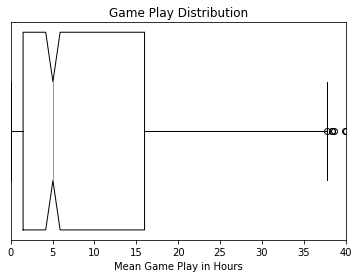

In [77]:
ax = plt.gca()
ax.set_title('Game Play Distribution')
ax.boxplot(stats_df[('time', 'mean')]/60, vert=False,manage_ticks=False, notch=True)
plt.xlabel("Mean Game Play in Hours")
ax.set_xlim([0, 40])
ax.set_yticks([])
plt.show()

I had a hunch that more popular games got played more, however, I feel like this data-set is still too small the verify this hunch.

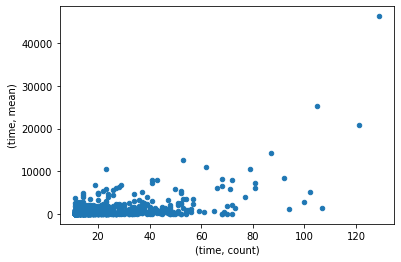

In [71]:
stats_df.plot.scatter(x=('time', 'count'), y=('time', 'mean'))

In [ ]:
We can create a new filtered dataframe that only contains the result of a single game. 

In [95]:
cc_df = games_df[games_df['gamename'] == "counter-strike: global offensive"]
cc_df

,gameid,time,gamename
13196,730,742,counter-strike: global offensive
13197,730,16019,counter-strike: global offensive
13198,730,1781,counter-strike: global offensive
13199,730,0,counter-strike: global offensive
13200,730,0,counter-strike: global offensive
...,...,...,...
13320,730,3867,counter-strike: global offensive
13321,730,174176,counter-strike: global offensive
13322,730,186988,counter-strike: global offensive
13323,730,103341,counter-strike: global offensive


It is supprizing how many hours certain people play in Counter-Strike. The highest number in the dataset was 8,444 hours or 352 days! 

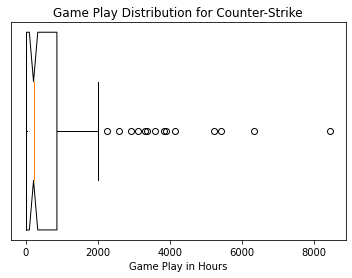

In [99]:
ax = plt.gca()
ax.set_title('Game Play Distribution for Counter-Strike')
ax.boxplot(cc_df['time']/60, vert=False,manage_ticks=False, notch=True)
plt.xlabel("Game Play in Hours")
ax.set_yticks([])
plt.show()

Viewing the distribution for a different game like Unturned, yields a vastly different distribution than Counter-Strike. I believe the key difference is that Counter-Strike is played competitively where Unturned is a more leasurely game. It is likely that competative gamers skew the distribution of Counter-Strike to be very high. 

In [102]:
u_df = games_df[games_df['gamename'] == "unturned"]
u_df

,gameid,time,gamename
167,304930,140,unturned
168,304930,723,unturned
169,304930,1002,unturned
170,304930,1002,unturned
171,304930,0,unturned
...,...,...,...
269,304930,97,unturned
270,304930,768,unturned
271,304930,1570,unturned
272,304930,23,unturned


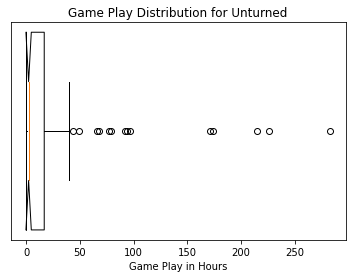

In [103]:
ax = plt.gca()
ax.set_title('Game Play Distribution for Unturned')
ax.boxplot(u_df['time']/60, vert=False,manage_ticks=False, notch=True)
plt.xlabel("Game Play in Hours")
ax.set_yticks([])
plt.show()

Next, I made a dataframe just containing the raw data points of games that had a aggregate count of over 80. For the sample size of the crawl that I did, having a count of 80, would make the game "popular". Since we only have 485 players indexed, having over 80 entries means that over 17% of people scrapped had the game. Glancing at the results, it is easy to verify that the games returned were very popular. 

In [142]:
df1 = games_df[games_df['gamename'].map(games_df['gamename'].value_counts()) > 80]
df1['time'] = df1['time']/60
df1

<ipython-input-142-49f39d385a2a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['time'] = df1['time']/60


,gameid,time,gamename
167,304930,2.333333,unturned
168,304930,12.050000,unturned
169,304930,16.700000,unturned
170,304930,16.700000,unturned
171,304930,0.000000,unturned
...,...,...,...
22682,578080,51.883333,playerunknown's battlegrounds
22683,578080,47.616667,playerunknown's battlegrounds
22684,578080,30.650000,playerunknown's battlegrounds
22685,578080,170.083333,playerunknown's battlegrounds


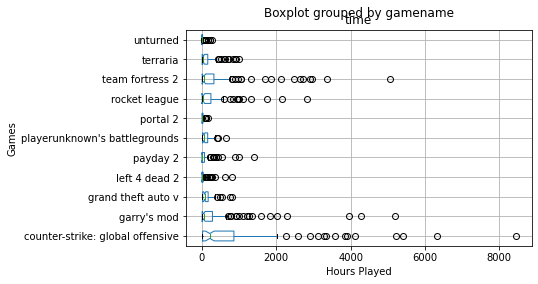

In [143]:
ax = plt.gca()
ax.set_title('Steps Distribution for July\n')
df1.boxplot(column=["time"], by='gamename',ax=ax, notch=True, vert=False)
plt.xlabel("Hours Played")
plt.ylabel("Games")
plt.show()

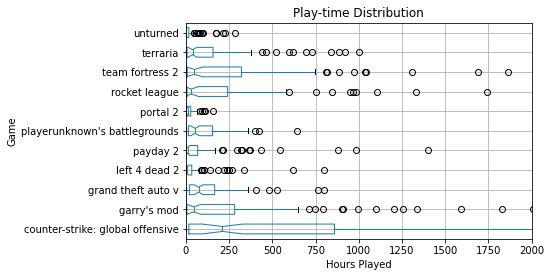

In [153]:
ax = df1.boxplot(column=["time"], by='gamename', notch=True, vert=False)
fig = ax.get_figure()
fig.suptitle('')
ax.set_title('Play-time Distribution')
plt.xlabel("Hours Played")
ax.set_xlim([0, 2000])
plt.ylabel("Game")
plt.savefig("playTimes.png", dpi=300, bbox_inches = "tight")

Overall this is really interesting to see how the distributions for different games vary. In the future I am going to re-run some of these analytics with even more data and possibly put them on my website as a interactive graph.